<a href="https://colab.research.google.com/github/JulienGremillot/du_coup/blob/main/du_coup_tf_lite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install tflite-model-maker

     |████████████████████████████████| 616 kB 5.5 MB/s 
     |████████████████████████████████| 596 kB 42.0 MB/s 
     |████████████████████████████████| 120 kB 32.4 MB/s 
     |████████████████████████████████| 1.1 MB 36.2 MB/s 
     |████████████████████████████████| 1.2 MB 15.0 MB/s 
     |████████████████████████████████| 77 kB 3.1 MB/s 
     |████████████████████████████████| 840 kB 28.1 MB/s 
     |████████████████████████████████| 87 kB 3.5 MB/s 
     |████████████████████████████████| 234 kB 45.0 MB/s 
     |████████████████████████████████| 1.1 MB 45.0 MB/s 
     |████████████████████████████████| 6.4 MB 50.8 MB/s 
     |████████████████████████████████| 3.4 MB 45.4 MB/s 
     |████████████████████████████████| 25.3 MB 6.0 MB/s 
     |████████████████████████████████| 47.8 MB 1.6 MB/s 
     |████████████████████████████████| 99 kB 8.6 MB/s 
     |████████████████████████████████| 352 kB 51.5 MB/s 
     |████████████████████████████████| 462 kB 55.5 MB/s 
     |███████████████

In [2]:
import os
import glob
import random
import shutil

import librosa
import soundfile as sf
from IPython.display import Audio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tflite_model_maker as mm
from tflite_model_maker import audio_classifier
from tflite_model_maker.config import ExportFormat

print(f"TensorFlow Version: {tf.__version__}")
print(f"Model Maker Version: {mm.__version__}")

TensorFlow Version: 2.8.0
Model Maker Version: 0.3.4


In [3]:
from google.colab import drive
import os
drive.mount("/content/gdrive", force_remount=False)

Mounted at /content/gdrive


In [9]:
import shutil
import pathlib
dataset_dir = '/tmp/data'
src_du_coup = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/du_coup')
dst_du_coup = pathlib.Path(os.path.join(dataset_dir, 'du_coup'))
if not dst_du_coup.exists():
  print('Copie le répertoire', src_du_coup, 'vers', dst_du_coup)
  shutil.copytree(src_du_coup, dst_du_coup)
else:
  print('Le répertoire', dst_du_coup, 'existe déjà.')

Le répertoire /tmp/data/du_coup existe déjà.


In [7]:
tf.keras.utils.get_file('speech_commands_v0.01.tar.gz',
                        'http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz',
                        cache_dir='./',
                        cache_subdir='dataset-speech',
                        extract=True)
tf.keras.utils.get_file('background_audio.zip',
                        'https://storage.googleapis.com/download.tensorflow.org/models/tflite/sound_classification/background_audio.zip',
                        cache_dir='./',
                        cache_subdir='dataset-background',
                        extract=True)

1081344/1072437 [==============================] - 0s 0us/step


'./dataset-background/background_audio.zip'

In [8]:
# Create a list of all the background wav files
files = glob.glob(os.path.join('./dataset-speech/_background_noise_', '*.wav'))
files = files + glob.glob(os.path.join('./dataset-background', '*.wav'))

background_dir = './background'
os.makedirs(background_dir, exist_ok=True)

# Loop through all files and split each into several one-second wav files
for file in files:
  filename = os.path.basename(os.path.normpath(file))
  print('Splitting', filename)
  name = os.path.splitext(filename)[0]
  rate = librosa.get_samplerate(file)
  length = round(librosa.get_duration(filename=file))
  for i in range(length - 1):
    start = i * rate
    stop = (i * rate) + rate
    data, _ = sf.read(file, start=start, stop=stop)
    sf.write(os.path.join(background_dir, name + str(i) + '.wav'), data, rate)

Splitting doing_the_dishes.wav
Splitting pink_noise.wav
Splitting exercise_bike.wav
Splitting dude_miaowing.wav
Splitting running_tap.wav
Splitting white_noise.wav
Splitting throat_clearing.wav
Splitting silence.wav


In [10]:
def move_background_dataset(dataset_dir):
  dest_dir = os.path.join(dataset_dir, 'background')
  if os.path.exists(dest_dir):
    files = glob.glob(os.path.join(background_dir, '*.wav'))
    for file in files:
      shutil.move(file, dest_dir)
  else:
    shutil.move(background_dir, dest_dir)

In [11]:
# Move background samples into custom dataset
move_background_dataset(dataset_dir)

# Now we separate some of the files that we'll use for testing:
test_dir = './dataset-test'
test_data_ratio = 0.2
dirs = glob.glob(os.path.join(dataset_dir, '*/'))
for dir in dirs:
  files = glob.glob(os.path.join(dir, '*.wav'))
  test_count = round(len(files) * test_data_ratio)
  random.seed(42)
  random.shuffle(files)
  # Move test samples:
  for file in files[:test_count]:
    class_dir = os.path.basename(os.path.normpath(dir))
    os.makedirs(os.path.join(test_dir, class_dir), exist_ok=True)
    os.rename(file, os.path.join(test_dir, class_dir, os.path.basename(file)))
  print('Moved', test_count, 'images from', class_dir)

Moved 85 images from background
Moved 37 images from du_coup


In [12]:
def get_random_audio_file(samples_dir):
  files = os.path.abspath(os.path.join(samples_dir, '*/*.wav'))
  files_list = glob.glob(files)
  random_audio_path = random.choice(files_list)
  return random_audio_path

def show_sample(audio_path):
  audio_data, sample_rate = sf.read(audio_path)
  class_name = os.path.basename(os.path.dirname(audio_path))
  print(f'Class: {class_name}')
  print(f'File: {audio_path}')
  print(f'Sample rate: {sample_rate}')
  print(f'Sample length: {len(audio_data)}')

  plt.title(class_name)
  plt.plot(audio_data)
  display(Audio(audio_data, rate=sample_rate))

Class: du_coup
File: /content/dataset-test/du_coup/du_coup_gabriel_08.wav
Sample rate: 16000
Sample length: 7616


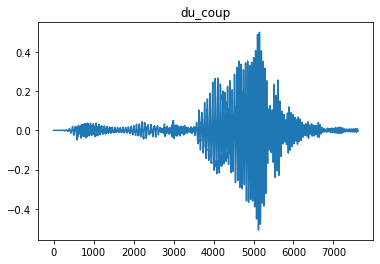

In [13]:
random_audio = get_random_audio_file(test_dir)
show_sample(random_audio)

In [14]:
spec = audio_classifier.BrowserFftSpec()

INFO:tensorflow:Checkpoints are stored in /tmp/tmpncp474_t
32768/18467 [=====================================================] - 0s 0us/step
16384/203 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [15]:
train_data_ratio = 0.8
train_data = audio_classifier.DataLoader.from_folder(
    spec, dataset_dir, cache=True)
train_data, validation_data = train_data.split(train_data_ratio)
test_data = audio_classifier.DataLoader.from_folder(
    spec, test_dir, cache=True)

In [16]:
batch_size = 25
epochs = 25
model = audio_classifier.create(train_data, spec, validation_data, batch_size, epochs)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 42, 225, 8)        136       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 112, 8)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 109, 32)       2080      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 51, 32)         8224      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 25, 32)       

In [17]:
model.evaluate(test_data)

3/3 [==============================] - 6s 2s/step - loss: 0.1792 - acc: 0.9884


[0.17916922271251678, 0.9883720874786377]

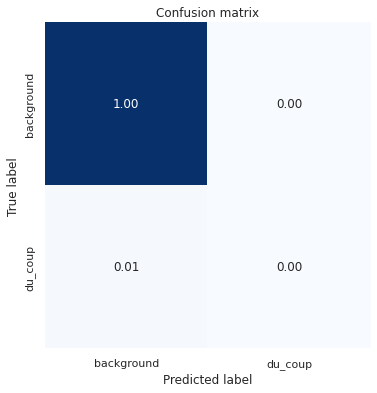

In [18]:
def show_confusion_matrix(confusion, test_labels):
  """Compute confusion matrix and normalize."""
  confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
  sns.set(rc = {'figure.figsize':(6,6)})
  sns.heatmap(
      confusion_normalized, xticklabels=test_labels, yticklabels=test_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True, cbar=False)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

confusion_matrix = model.confusion_matrix(test_data)
show_confusion_matrix(confusion_matrix.numpy(), test_data.index_to_label)

In [20]:
TFLITE_FILENAME = 'browserfft-speech.tflite'
SAVE_PATH = './models'
print(f'Exporting the model to {SAVE_PATH}')
model.export(SAVE_PATH, tflite_filename=TFLITE_FILENAME)
model.export(SAVE_PATH, export_format=[mm.ExportFormat.SAVED_MODEL, mm.ExportFormat.LABEL])

Exporing the model to ./models
INFO:tensorflow:Assets written to: /tmp/tmpqn2zldz7/assets
INFO:tensorflow:TensorFlow Lite model exported successfully: ./models/browserfft-speech.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./models/browserfft-speech.tflite


INFO:tensorflow:Assets written to: ./models/saved_model/assets


INFO:tensorflow:Assets written to: ./models/saved_model/assets


INFO:tensorflow:Saving labels in ./models/labels.txt


INFO:tensorflow:Saving labels in ./models/labels.txt


In [21]:
 !pip install -q tflite_support

In [22]:
from tflite_support import metadata
import json

def get_labels(model):
  """Returns a list of labels, extracted from the model metadata."""
  displayer = metadata.MetadataDisplayer.with_model_file(model)
  labels_file = displayer.get_packed_associated_file_list()[0]
  labels = displayer.get_associated_file_buffer(labels_file).decode()
  return [line for line in labels.split('\n')]

def get_input_sample_rate(model):
  """Returns the model's expected sample rate, from the model metadata."""
  displayer = metadata.MetadataDisplayer.with_model_file(model)
  metadata_json = json.loads(displayer.get_metadata_json())
  input_tensor_metadata = metadata_json['subgraph_metadata'][0][
          'input_tensor_metadata'][0]
  input_content_props = input_tensor_metadata['content']['content_properties']
  return input_content_props['sample_rate']

---prediction---
Class: background
Score: 1.0
----truth----
Class: du_coup
File: /content/dataset-test/du_coup/du_coup_p_01.wav
Sample rate: 16000
Sample length: 14175


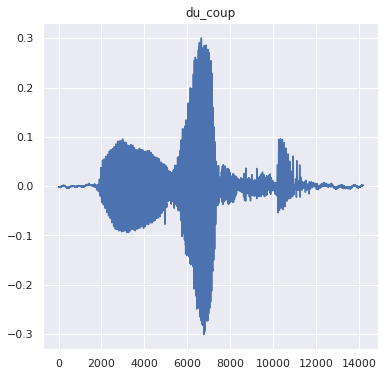

In [23]:
# Get a WAV file for inference and list of labels from the model
tflite_file = os.path.join(SAVE_PATH, TFLITE_FILENAME)
labels = get_labels(tflite_file)
random_audio = get_random_audio_file(test_dir)

# Ensure the audio sample fits the model input
interpreter = tf.lite.Interpreter(tflite_file)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_size = input_details[0]['shape'][1]
sample_rate = get_input_sample_rate(tflite_file)
audio_data, _ = librosa.load(random_audio, sr=sample_rate)
if len(audio_data) < input_size:
  audio_data.resize(input_size)
audio_data = np.expand_dims(audio_data[:input_size], axis=0)

# Run inference
interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'], audio_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

# Display prediction and ground truth
top_index = np.argmax(output_data[0])
label = labels[top_index]
score = output_data[0][top_index]
print('---prediction---')
print(f'Class: {label}\nScore: {score}')
print('----truth----')
show_sample(random_audio)

In [24]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(tflite_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>